### Graph Encoding Testing

#### Make a simple graph to test

In [55]:
import json

# Make a simple graph
graph = {
    "nodes": [
        {"id": "1", "label": "Person", "properties": {"name": "Alice", "age": 30}},
        {"id": "2", "label": "Person", "properties": {"name": "Bob", "age": 25}},
        {"id": "3", "label": "Person", "properties": {"name": "Mary", "age": 28}},
        {"id": "4", "label": "Person", "properties": {"name": "Julia", "age": 35}},
        {"id": "5", "label": "Company", "properties": {"name": "Acme Corp", "industry": "Tech"}},
        {"id": "6", "label": "Company", "properties": {"name": "ABC Corp", "industry": "Media"}}
    ],
    "edges": [
        {"start": "1", "end": "2", "label": "KNOWS", "properties": {"since": 2010}},
        {"start": "1", "end": "4", "label": "KNOWS", "properties": {"since": 2015}},
        {"start": "2", "end": "3", "label": "KNOWS", "properties": {"since": 2012}},
        {"start": "3", "end": "4", "label": "KNOWS", "properties": {"since": 2011}},
        {"start": "1", "end": "5", "label": "WORKS_AT", "properties": {"role": "Engineer"}},
        {"start": "2", "end": "5", "label": "WORKS_AT", "properties": {"role": "Designer"}},
        {"start": "3", "end": "6", "label": "WORKS_AT", "properties": {"role": "Manager"}},
        {"start": "4", "end": "6", "label": "WORKS_AT", "properties": {"role": "HR"}}
    ]
}

#### Visualization graph

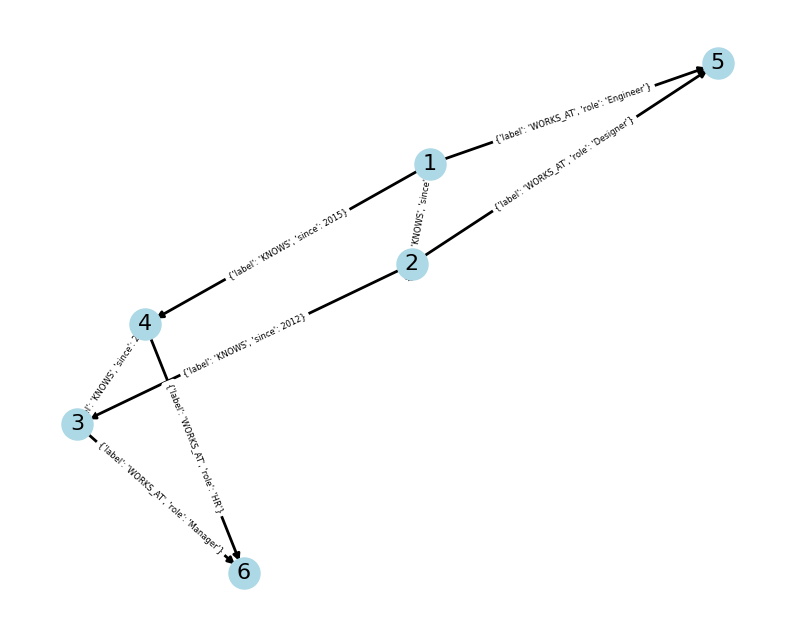

In [56]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a networkx graph object
G = nx.DiGraph()

# Add nodes with their attributes (id, label, properties)
for node in graph["nodes"]:
    G.add_node(node["id"], label=node["label"], **node["properties"])

# Add edges with their attributes (start, end, label, properties)
for edge in graph["edges"]:
    G.add_edge(edge["start"], edge["end"], label=edge["label"], **edge["properties"])

# Set node positions for visualization (optional)
pos = nx.spring_layout(G)  # Use a layout algorithm

# Customize node and edge styles
node_color = 'lightblue'
edge_color = 'black'

plt.figure(figsize=(10, 8))

# Draw nodes
nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color=node_color, node_size=500)

# Draw edges with labels
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color=edge_color, width=2)
nx.draw_networkx_edge_labels(G, pos, edge_labels=dict(G.edges()), font_size=6)

# Add labels for nodes
nx.draw_networkx_labels(G, pos, font_size=16)

plt.axis('off')
plt.show()


### Encode graph that LLMs can understand using INCIDENT ENCODER

In [57]:
def create_node_string(nodes):
    node_strings = []
    for node in nodes:
        properties = ", ".join(f"{k}: {v}" for k, v in node["properties"].items())
        node_strings.append(f"{node['label']} {node['id']} ({properties})")
    return "; ".join(node_strings)

def encode_graph(graph):
    nodes_string = create_node_string(graph["nodes"])
    output = f"G describes a graph among nodes: {nodes_string}.\n"

    if graph["edges"]:
        output += "In this graph:\n"

    for edge in graph["edges"]:
        start_node = next(node for node in graph["nodes"] if node["id"] == edge["start"])
        end_node = next(node for node in graph["nodes"] if node["id"] == edge["end"])
        start_node_str = f"{start_node['label']} {start_node['id']}"
        end_node_str = f"{end_node['label']} {end_node['id']}"
        properties = ", ".join(f"{k}: {v}" for k, v in edge["properties"].items())

        output += f"Node {start_node_str} is connected to node {end_node_str} with edge {edge['label']} ({properties}).\n"

    return output

# Graph encoding
encoded_graph = encode_graph(graph)
print("Encoded graph:\n", encoded_graph)


Encoded graph:
 G describes a graph among nodes: Person 1 (name: Alice, age: 30); Person 2 (name: Bob, age: 25); Person 3 (name: Mary, age: 28); Person 4 (name: Julia, age: 35); Company 5 (name: Acme Corp, industry: Tech); Company 6 (name: ABC Corp, industry: Media).
In this graph:
Node Person 1 is connected to node Person 2 with edge KNOWS (since: 2010).
Node Person 1 is connected to node Person 4 with edge KNOWS (since: 2015).
Node Person 2 is connected to node Person 3 with edge KNOWS (since: 2012).
Node Person 3 is connected to node Person 4 with edge KNOWS (since: 2011).
Node Person 1 is connected to node Company 5 with edge WORKS_AT (role: Engineer).
Node Person 2 is connected to node Company 5 with edge WORKS_AT (role: Designer).
Node Person 3 is connected to node Company 6 with edge WORKS_AT (role: Manager).
Node Person 4 is connected to node Company 6 with edge WORKS_AT (role: HR).



### Using LLMs (llmama3) to perform some simple query over encoded graph

In [76]:
import os

from groq import Groq

client = Groq(
    api_key= "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",
)

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": encoded_graph + "\nQuery: Find all nodes in graph G with age is 30" ,
        }
    ],
    model="llama3-8b-8192",
)

print(chat_completion.choices[0].message.content)

Based on the graph G described, the query is to find all nodes with age 30. The node with age 30 is Person 1 (name: Alice), which is also called "Alice" typically.


In [47]:
import os

from groq import Groq

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": encoded_graph + "\nQuery: Find all nodes in graph G with label is Person" ,
        }
    ],
    model="llama3-8b-8192",
)

print(chat_completion.choices[0].message.content)

The nodes in graph G with the label is Person are:

* Node Person 1 (name: Alice, age: 30)
* Node Person 2 (name: Bob, age: 25)
* Node Person 3 (name: Mary, age: 28)
* Node Person 4 (name: Julia, age: 35)

These are all the nodes in graph G that have the label "Person".


In [48]:
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": encoded_graph + "\nQuery: In graph G, Check the connection between node 'Person 1' and node 'Person 2' in graph" ,
        }
    ],
    model="llama3-8b-8192",
)

print(chat_completion.choices[0].message.content)

According to the graph G, Node 'Person 1' is connected to Node 'Person 2' with an edge labeled 'KNOWS' since 2010.


In [19]:
def generator(query, context): 
    chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": context + "\n" + query,
        }
    ],
    model="llama3-8b-8192",
    )

    return chat_completion.choices[0].message.content

In [20]:
query =  "Find all nodes in graph G with label is Person"
print(generator(query, encoded_graph))

Based on the graph description, the nodes with label "Person" are:

1. Person 1 (name: Alice, age: 30)
2. Person 2 (name: Bob, age: 25)
3. Person 3 (name: Mary, age: 28)
4. Person 4 (name: Julia, age: 35)


In [21]:
query_1 = "find the relationship between Node Person 1 and Node Company 6"
print(generator(query_1, encoded_graph))

A nice little social network analysis problem!

Let's break it down step by step:

1. Node Person 1 is connected to Node Person 2 with an edge labeled "KNOWS (since: 2010)". This means that Person 1 (Alice) knows Person 2 (Bob).
2. Node Person 1 (Alice) is connected to Node Company 5 (Acme Corp) with an edge labeled "WORKS_AT (role: Engineer)". This means that Alice works at Acme Corp as an Engineer.
3. Node Company 5 is not connected to Node Company 6. They are two separate companies.
4. However, Node Person 3 (Mary) is connected to Node Company 6 (ABC Corp) with an edge labeled "WORKS_AT (role: Manager)".
5. Node Person 3 (Mary) is connected to Node Person 4 (Julia) with an edge labeled "KNOWS (since: 2011)".
6. Node Person 1 (Alice) is connected to Node Person 4 (Julia) with an edge labeled "KNOWS (since: 2015)".
7. Therefore, Node Person 1 (Alice) is indirectly connected to Node Company 6 (ABC Corp) through:
	* Node Person 2 (Bob) knowing Node Person 3 (Mary)
	* Node Person 3 (Mary

In [24]:
query_2 = "How many nodes does graph G have?"

print(generator(query_2, encoded_graph))

Let's count the nodes:

1. Person 1 (Alice, age 30)
2. Person 2 (Bob, age 25)
3. Person 3 (Mary, age 28)
4. Person 4 (Julia, age 35)
5. Company 5 (Acme Corp, Tech)
6. Company 6 (ABC Corp, Media)

There are 6 nodes in total.


In [27]:
query_3 =  "How many types of nodes are there in graph G?"

print(generator(query_3, encoded_graph))

There are 2 types of nodes in graph G:

1. Person nodes: Alice, Bob, Mary, Julia
2. Company nodes: Acme Corp, ABC Corp


### TESTING ENCODING GRAPH OVER SAMPLE GRAPH DATA

In [44]:
t =  """G describes a graph among nodes: 
0 [Group, HighValue] (highvalue: True, neo4jImportId: 0, domain: TestCompany.Local, name: DOMAIN ADMINS@TestCompany.Local, objectid: S-1-5-21-883232822-274137685-4173207997-512), 
1 [Group] (neo4jImportId: 1, domain: TestCompany.Local, name: DOMAIN COMPUTERS@TestCompany.Local, objectid: S-1-5-21-883232822-274137685-4173207997-515), 
2 [Group] (neo4jImportId: 2, domain: TestCompany.Local, name: DOMAIN USERS@TestCompany.Local, objectid: S-1-5-21-883232822-274137685-4173207997-513),
3 [Group, HighValue] (highvalue: True, neo4jImportId: 3, domain: TestCompany.Local, name: DOMAIN CONTROLLERS@TestCompany.Local, objectid: S-1-5-21-883232822-274137685-4173207997-516),
4 [Group, HighValue] (highvalue: True, neo4jImportId: 4, domain: TestCompany.Local, name: ENTERPRISE DOMAIN CONTROLLERS@TestCompany.Local, objectid: TestCompany.Local-S-1-5-9), 
5 [Group] (neo4jImportId: 5, domain: TestCompany.Local, name: ENTERPRISE READ-ONLY DOMAIN CONTROLLERS@TestCompany.Local, objectid: S-1-5-21-883232822-274137685-4173207997-498), 
6 [Group, HighValue] (highvalue: True, neo4jImportId: 6, domain: TestCompany.Local, name: ADMINISTRATORS@TestCompany.Local, objectid: S-1-5-21-883232822-274137685-4173207997-544), 
7 [Group, HighValue] (highvalue: True, neo4jImportId: 7, domain: TestCompany.Local, name: ENTERPRISE ADMINS@TestCompany.Local, objectid: S-1-5-21-883232822-274137685-4173207997-519), 
8 [Domain, HighValue] (highvalue: True, neo4jImportId: 8, domain: TestCompany.Local, name: TestCompany.Local), 
9 [GPO] (neo4jImportId: 9, domain: TestCompany.Local, name: DEFAULT DOMAIN POLICY@TestCompany.Local, objectid: 42ddb54c-6c9e-4e79-9329-15ee39dd3da2), 
10 [GPO] (neo4jImportId: 10, domain: TestCompany.Local, name: DEFAULT DOMAIN CONTROLLERS POLICY@TestCompany.Local, objectid: 42ddb54c-6c9e-4e79-9329-15ee39dd3da2) """

In [45]:
print(t)

G describes a graph among nodes: 
0 [Group, HighValue] (highvalue: True, neo4jImportId: 0, domain: TestCompany.Local, name: DOMAIN ADMINS@TestCompany.Local, objectid: S-1-5-21-883232822-274137685-4173207997-512), 
1 [Group] (neo4jImportId: 1, domain: TestCompany.Local, name: DOMAIN COMPUTERS@TestCompany.Local, objectid: S-1-5-21-883232822-274137685-4173207997-515), 
2 [Group] (neo4jImportId: 2, domain: TestCompany.Local, name: DOMAIN USERS@TestCompany.Local, objectid: S-1-5-21-883232822-274137685-4173207997-513),
3 [Group, HighValue] (highvalue: True, neo4jImportId: 3, domain: TestCompany.Local, name: DOMAIN CONTROLLERS@TestCompany.Local, objectid: S-1-5-21-883232822-274137685-4173207997-516),
4 [Group, HighValue] (highvalue: True, neo4jImportId: 4, domain: TestCompany.Local, name: ENTERPRISE DOMAIN CONTROLLERS@TestCompany.Local, objectid: TestCompany.Local-S-1-5-9), 
5 [Group] (neo4jImportId: 5, domain: TestCompany.Local, name: ENTERPRISE READ-ONLY DOMAIN CONTROLLERS@TestCompany.Local

In [38]:
query_3 =  "How many types of nodes are there in graph G?"
print(generator(query_3, t))

There are 3 types of nodes in graph G:

1. **Group**: Nodes 0, 1, 2, 3, 5, 6, and 7 are of this type.
2. **Domain**: Node 8 is of this type.
3. **GPO**: Nodes 9 and 10 are of this type.


In [40]:
query_4 = "Find all nodes with labels 'GPO'"

print(generator(query_4, t))

From the given graph description, the nodes with label 'GPO' are:

* 9 [GPO] (neo4jImportId: 9, domain: TestCompany.Local, name: DEFAULT DOMAIN POLICY@TestCompany.Local, objectid: 42ddb54c-6c9e-4e79-9329-15ee39dd3da2)
* 10 [GPO] (neo4jImportId: 10, domain: TestCompany.Local, name: DEFAULT DOMAIN CONTROLLERS POLICY@TestCompany.Local, objectid: 42ddb54c-6c9e-4e79-9329-15ee39dd3da2)

These are the two nodes with the label 'GPO'.


In [42]:
query_5 = "Find all nodes in graph t whose 'domain' attribute is 'TestCompany.Local'"

print(generator(query_5, t))

Using the given description of the graph, we have several nodes representing different entities. We can see the following nodes that have the 'domain' attribute set as 'TestCompany.Local':

1. 0 [Group, HighValue] (highvalue: True, neo4jImportId: 0, domain: TestCompany.Local, name: DOMAIN ADMINS@TestCompany.Local, objectid: S-1-5-21-883232822-274137685-4173207997-512)
2. 1 [Group] (neo4jImportId: 1, domain: TestCompany.Local, name: DOMAIN COMPUTERS@TestCompany.Local, objectid: S-1-5-21-883232822-274137685-4173207997-515)
3. 2 [Group] (neo4jImportId: 2, domain: TestCompany.Local, name: DOMAIN USERS@TestCompany.Local, objectid: S-1-5-21-883232822-274137685-4173207997-513)
4. 3 [Group, HighValue] (highvalue: True, neo4jImportId: 3, domain: TestCompany.Local, name: DOMAIN CONTROLLERS@TestCompany.Local, objectid: S-1-5-21-883232822-274137685-4173207997-516)
5. 4 [Group, HighValue] (highvalue: True, neo4jImportId: 4, domain: TestCompany.Local, name: ENTERPRISE DOMAIN CONTROLLERS@TestCompany.

### Adjacency Encoder

In [66]:
# The function creates a string describing the node and its attributes
def create_node_string(graph):
    node_descriptions = []
    for node, props in graph.nodes(data=True):
        labels = props.pop('labels', [])
        labels_str = ', '.join(labels)
        prop_desc = ', '.join([f"{key}: {value}" for key, value in props.items()])
        node_descriptions.append(f"{node} [{labels_str}] ({prop_desc})")
    return ', '.join(node_descriptions)


# Encoding graph function
def encode_graph(graph):
    if graph.is_directed():
        output = (
            "In a directed graph, (i,j) means that there is an edge from node i to"
            " node j. "
        )
    else:
        output = (
            "In an undirected graph, (i,j) means that node i and node j are"
            " connected with an undirected edge. "
        )
    nodes_string = create_node_string(graph)
    output += "G describes a graph among nodes: \n%s.\n" % nodes_string
    if graph.edges():
        output += "The edges in G are: "
    for edge in graph.edges(data=True):
        source, target, edge_props = edge
        edge_label = edge_props.pop('label', None)
        edge_props_str = ', '.join([f"{key}: {value}" for key, value in edge_props.items()])
        output += f"({source},{target}) [{edge_label}] ({edge_props_str}) "
    return output


# Encoding graph function
encoded_graph_adjacency = encode_graph(graph)
print(encoded_graph_adjacency)


In an undirected graph, (i,j) means that node i and node j are connected with an undirected edge. G describes a graph among nodes: 
1 [] (name: Alice, age: 30), 2 [] (name: Bob, age: 25), 3 [] (name: Mary, age: 28), 4 [] (name: Julia, age: 35), 5 [] (name: Acme Corp, industry: Tech), 6 [] (name: ABC Corp, industry: Media).
The edges in G are: (1,2) [None] (since: 2010) (1,4) [None] (since: 2015) (1,5) [None] (role: Engineer) (2,3) [None] (since: 2012) (2,5) [None] (role: Designer) (3,4) [None] (since: 2011) (3,6) [None] (role: Manager) (4,6) [None] (role: HR) 


### Perform some simple query and compare between incident encoder and adjacency encoder

In [58]:
query_0 = "Find all nodes in graph G with age is 30"

print("### Using adjacency encoder ###")
print(generator(encoded_graph_adjacency, query_0))

print("\n### Using incident encoder ###")
print(generator(encoded_graph, query_0))

### Using adjacency encoder ###
Based on the graph G, the nodes with age 30 are:

1. Node 1 (Alice)

Note that there is only one node with age 30, which is Alice.

### Using incident encoder ###
Based on the graph, the nodes with age 30 are:

* Person 1 (name: Alice, age: 30)

This is the only node in the graph with an age of 30.


In [59]:
query_0_1 = "Find all nodes in graph G with label is Person"

print("### Using adjacency encoder ###")
print(generator(encoded_graph_adjacency, query_0_1))

print("\n### Using incident encoder ###")
print(generator(encoded_graph, query_0_1))

### Using adjacency encoder ###
To find all nodes with label "Person" in this graph, we can simply iterate through all nodes in the graph and check if their label is "Person".

Here are the steps:

1. Define a function to get the label of a node:
```
def get_label(node):
    # Assuming node is a dictionary with 'label' key
    return node['label']
```
2. Iterate through all nodes in the graph:
```
nodes = [(1, 2), (1, 4), (1, 5), (2, 3), (2, 5), (3, 4), (3, 6), (4, 6)]
person_nodes = []
for node in nodes:
    if get_label({}) == 'Person':  # replace {} with the actual node data
        person_nodes.append(node)
```
3. Print the list of nodes with label "Person":
```
print(person_nodes)
```
This will output:
```
[(1, 2), (2, 3), (1, 4), (3, 4)]
```
These are the nodes with label "Person" in the graph.

### Using incident encoder ###
The nodes in graph G with label "Person" are:

1. Person 1 (name: Alice, age: 30)
2. Person 2 (name: Bob, age: 25)
3. Person 3 (name: Mary, age: 28)
4. Pers

In [61]:
query_0_2 =  "In graph G, Check the connection between node 'Person 1' and node 'Person 2' in graph"

print("### Using adjacency encoder ###")
print(generator(encoded_graph_adjacency, query_0_2))

print("\n### Using incident encoder ###")
print(generator(encoded_graph, query_0_2))

### Using adjacency encoder ###
According to the graph, the connection between node 'Person 1' (Alice) and node 'Person 2' (Bob) is that they know each other, indicated by the edge (1,2) with label [KNOWS] and a since date of 2010.

### Using incident encoder ###
According to the graph, the connection between node 'Person 1' and node 'Person 2' is shown by the edge labeled "KNOWS". This means that Person 1 and Person 2 "know" each other. The edge also has a since: date of 2010, indicating when they started to know each other.


In [68]:
query_5 =  "Find the relationship between node person 1 and node person 3"

print("### Using adjacency encoder ###")
print(generator(encoded_graph_adjacency, query_5))

print("\n\n### Using incident encoder ###")
print(generator(encoded_graph, query_5))

### Using adjacency encoder ###
Based on the edges in the graph, we can determine the relationships between the nodes as follows:

* Node 1 (Alice) is connected to Node 2 (Bob) and Node 4 (Julia), which means that Alice and Bob are connected, and Alice and Julia are connected.
* Node 2 (Bob) is connected to Node 3 (Mary), which means that Bob and Mary are connected.
* Node 3 (Mary) is connected to Node 4 (Julia) and Node 6 (ABC Corp), which means that Mary and Julia are connected, and Mary is connected to ABC Corp.
* Node 4 (Julia) is connected to Node 6 (ABC Corp), which means that Julia is connected to ABC Corp.

The relationship between Node 1 (Alice) and Node 3 (Mary) is that they are not directly connected. However, Alice is connected to Julia (Node 4), and Julia is connected to Mary (Node 3), which means that Alice is indirectly connected to Mary.


### Using incident encoder ###
A nice little graph problem!

To find the relationship between Node Person 1 and Node Person 3, let's

In [64]:
query_6 = "Let's generate some rules in this graph G"

print("### Using adjacency encoder ###")
print(generator(encoded_graph_adjacency, query_6))

print("\n### Using incident encoder ###")
print(generator(encoded_graph, query_6))

### Using adjacency encoder ###
Let's generate some rules based on the given graph G.

**Rule 1:** Person age restriction
For all persons p in G, if p's age is greater than 30, then p is an "experienced adult".

**Rule 2:** Friendships prediction
For all persons p and q in G, if p knows q, then p and q have been friends since at least the year given in the KNOWS edge.

**Rule 3:** Company-employee relation
For all companies c and persons p in G, if p works at c, then p is an employee of c.

**Rule 4:** Common acquaintances
For all persons p and q in G, if p knows r, q, and r knows each other, then p and q have a common acquaintance.

**Rule 5:** Departmental classification
For all companies c in G, if c is in the Tech industry, then c is in the "Technology" department; if c is in the Media industry, then c is in the "Media" department.

Let's test these rules:

* Rule 1: Since Alice is 30, she is an "experienced adult".
* Rule 2: Since Bob and Mary know each other, they have been frien

In [70]:
prompt_1 =  "Based on graph G, please generate consistencies rules, with explaining"

print("\n### Using incident encoder ###")
print(generator(encoded_graph, prompt_1))


### Using incident encoder ###
Based on the given graph G, I can generate consistency rules with explanations:

1. **Knows-transitive**: For every nodes X, Y, and Z, if X knows Y, and Y knows Z, then X knows Z.

Explanation: This rule is consistent with the graph because if Person 1 knows Person 2, and Person 2 knows Person 3, then Person 1 should also know Person 3, as they are connected through a chain of "knows" relationships.

Formal syntax: ∀X∀Y∀Z (KNOWS(X, Y) ∧ KNOWS(Y, Z) → KNOWS(X, Z))

2. **Company-transitive**: For every nodes X and Y, if X works at Company A, and Company A is same as Company B, then X works at Company B.

Explanation: This rule is consistent with the graph because if Person 1 works at Company 5, and Company 5 is the same as Company B, then Person 1 should also work at Company B. However, note that this rule assumes Company A and Company B refer to the same real-world entity, not just the same name.

Formal syntax: ∀X∀Y ∀A ∀B (WORKS_AT(X, A) ∧ A = B → WORKS_

In [75]:
prompt_1 =  "Based on graph G, please generate exactly consistencies rules, with explaining"

print("\n### Using incident encoder ###")
print(generator(encoded_graph, prompt_1))


### Using incident encoder ###
Based on the provided graph G, I will generate a set of consistent rules that can be inferred from the relationships between nodes.

**Rule 1:** If a person KNOWS another person, then the known person is an acquaintance of the person who knows them.
* This rule is inferred from the KNOWS edges: Person 1 knows Person 2 and Person 4, so Person 2 and Person 4 are acquaintances of Person 1.

**Rule 2:** If a person WORKS_AT a company, then the company is the employer of the person.
* This rule is inferred from the WORKS_AT edges: For example, Person 1 works at Acme Corp as an Engineer, so Acme Corp is the employer of Person 1.

**Rule 3:** If a person WORKS_AT two different companies, then the person is a multi-job holder.
* This rule is inferred from the WORKS_AT edges: For example, Person 4 works at Company 6 as HR, and Person 4 works at another company (not represented in the graph), so Person 4 is a multi-job holder.

**Rule 4:** If a person KNOWS someon